In [100]:
# Import Modules
import numpy as np
from astropy import units as u
from astropy import constants as const

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

from ReadFile import Read
from CenterOfMass2 import CenterOfMass

In [101]:
### Constants ###
# R200 in kpc from previous calculations
R200 = 278.737

In [ ]:
class DensityProfile:
    ''' 
    This class creates the halo density profile of a galaxy and fits a Hernquist and NFW profile to it
    '''
    def __init__(self, filename, R200):
        ''' 
        Initialize class
        Inputs:
            filename: string
                Name of file to analyze
            R200: float
                R200 value in kpc where density within is x200 critical density of the universe. Treat R200 as maximum in array
        '''
        # Get file information
        self.Remnant_t, self.Remnant_p, self.Remnant_d = Read(filename)

        # get COM of remnant
        self.Remnant = CenterOfMass(filename, 1)
        # Error tolerance
        delta = 0.01
        # Decrease volume factor
        voldec = 2.0
        # This is the center of mass of the remnant
        self.Remnant_COMp = self.Remnant.COM_P(delta, voldec)

        # Step size (use 0.1 or 1 if testing)
        dr = 0.01
        # Initial radius (3 to avoid cusp and unresolved bits)
        r0 = 3
        # Define radius array
        self.radii = np.arange(r0, R200, dr)

        # Critical density of the universe in 1e10 M_Sun and kpc (no longer needed but will include anyways)
        self.pcrit = 1.277e-8 

    def radius_array(self):
        ''' 
        Function that returns radius array to be used for all plotting
        Inputs: 
            None
        Outputs:
            self.radii: np.array  
                Array of radii based on inputted R200 value
        '''
        return self.radii

    def Integrator(self):
        '''
        Make spheres and sum masses inside
        Inputs:
            None
        Outputs:
            masses: numpy array
                Total mass in each sphere
        '''
        # Determine particle distance from COM
        xnew = abs(self.Remnant_COMp[0].value - self.Remnant_d['x'])
        ynew = abs(self.Remnant_COMp[1].value - self.Remnant_d['y'])
        znew = abs(self.Remnant_COMp[2].value - self.Remnant_d['z'])

        # Find magnitude of particle distance
        rnew = np.sqrt(xnew**2 + ynew**2 + znew**2)

        # Initialize radius and mass array
        masses = np.zeros(len(self.radii))

        for radius_index in range(len(self.radii)):
            # Create index where particles are within sphere
            index = np.where(rnew < self.radii[radius_index])

            # Take masses of the particles in sphere
            masses[radius_index] = np.sum(self.Remnant_d['m'][index])

        return masses
    

    def Actual_Profile(self):
        ''' 
        Convert mass values into spherical density values 
        Inputs:
            None
        Outputs:
            densities: numpy array
                Array of densities at radius values
        '''
        # Integrate masses with respect to radius
        masses = self.Integrator()

        # Convert radii to sphere volume
        sphere_vol = (4/3) * np.pi * self.radii**3

        # Convert masses and volumes to densities
        densities = (masses)/sphere_vol

        return densities


    def HernquistProfile(self, r, a):
        ''' 
        Hernquist profile format from Hernquist 1990
        Inputs:
            r: variable
                Independent radius variable that density is dependent on
            a: paramater
                Scale length of remnant halo
        Outputs:
            func: function
                Hernquist profile function
        '''
        # Mass of the halo from simulation
        Mhalo = np.sum(self.Remnant_d['m'])

        # Simplify
        numerator = Mhalo*a
        denom = 2*np.pi*r*(r+a)**3
        
        # Combine
        func = numerator/denom

        return func
    
    def NFW(self, r, r_s):
        ''' 
        NFW profile format from Frenk 2012 paper
        Inputs:
            r: variable
                Independent radius variable that density is dependent on
            r_s: paramater
                Characteristic radius of the dm halo
        Outputs:
            func: function
            NFW profile function
        '''
        # Characteristic density taken from density of Hernquist (in 10^10 Msun and kpc^-3)
        rhodm = 0.00523025934031492

        # Write out function
        func = rhodm * (r/r_s)**-1 * (1+(r/r_s))**-2
    
        return func
    
    def FitProfile(self, profile, maxfev=600):
        '''
        Fit a given profile to the dark matter halo density curve
        Inputs:
            profile: string
                Either NFW or Hernquist, sets which profile to fit
            maxfev: (optional) integer
                Max number of iterations curve fit will complete before returning an error
        Outputs:
            Fit: np.array
                Model density profile. Plot with radius 
            popt: np.array
                Best-fit parameter value
            Residuals: np.array
                Residual array for the fit
        '''
        # Selecting model profile
        if profile == "NFW":
            func = self.NFW
            # Set initial guess
            p0 = 20
        elif profile == "Hernquist":
            func = self.HernquistProfile
            # Set initial guess
            p0 = 60
        else: 
            print("Invalid model profile. Must be 'NFW' or 'Hernquist'.")

        # Fitting Curve
        popt, pcov = curve_fit(func, self.radii, self.Actual_Profile(), p0=p0, maxfev=maxfev)
        # Fitting curve to data
        Fit = func(self.radii, popt[0])

        # Finding residuals array
        difference = self.Actual_Profile() - Fit
        
        return Fit, popt, difference



In [103]:
# Call instance of class for Remnant
Merger = DensityProfile("Merger_801.txt", R200)

In [104]:
# Get radii array
# All profiles will be based on this array
Halo_radii = Merger.radius_array()

In [105]:
# Find halo density
Halo_density = Merger.Actual_Profile()

In [106]:
# Fit Hernquist
Hernquist_fit, Hernquist_parameter, Hernquist_residuals = Merger.FitProfile("Hernquist")

In [107]:
# Fit NFW
NFW_fit, NFW_parameter, NFW_residuals = Merger.FitProfile("NFW")

In [113]:
# Find parameters of each fit
# Hernquist
print("Scale length, a, for Hernquist:", np.round(Hernquist_parameter[0], 2), "kpc")
print("Charatceristic radius, r_s, for NFW:", np.round(NFW_parameter[0], 2), "kpc")

Scale length, a, for Hernquist: 18.63 kpc
Charatceristic radius, r_s, for NFW: 24.14 kpc


In [117]:
# Find average residuals of each fit
avgHern_res = np.mean(Hernquist_residuals)
avgNFW_res = np.mean(NFW_residuals)

# Print results
print("Average Hernquist residual", np.round(avgHern_res, 7))
print("Average NFW residual", np.round(avgNFW_res, 7))

Average Hernquist residual -3.97e-05
Average NFW residual -0.00013


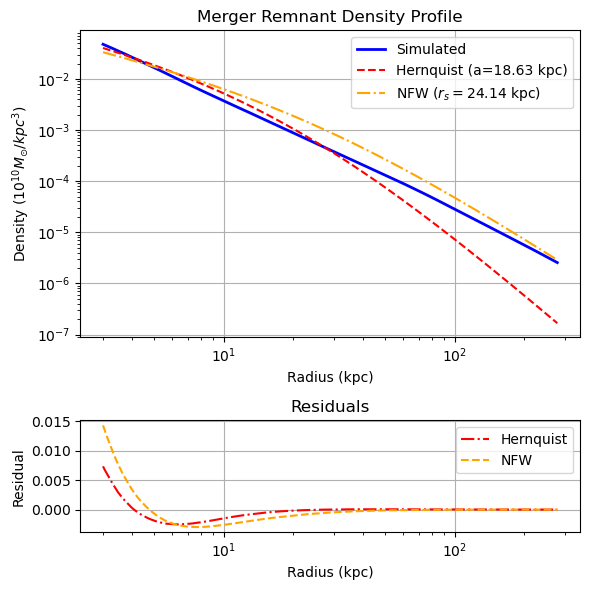

In [115]:
plt.figure(figsize=(6, 6))

# Main plot (larger)
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2) 
ax1.plot(Halo_radii, Halo_density, 'b', linewidth = 2, label='Simulated')
# Hernquist fit
ax1.plot(Halo_radii, Hernquist_fit, color = 'r', label='Hernquist (a='+str(np.round(Hernquist_parameter[0], 2))+' kpc)', linestyle='--')
# NFW1997 fit
ax1.plot(Halo_radii, NFW_fit, color = 'orange', label='NFW ($r_{s}=$'+str(np.round(NFW_parameter[0], 2))+' kpc)', linestyle='-.')

# Formatting
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid()
ax1.set(title='Merger Remnant Density Profile', xlabel='Radius (kpc)', ylabel='Density ($10^{10}M_{\odot}/kpc^{3}$)')
ax1.legend(loc='best')

# Smaller plot
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
# Hernquist Residuals
ax2.plot(Halo_radii, Hernquist_residuals, label='Hernquist', color='red', linestyle='-.')
# NFW Residuals
ax2.plot(Halo_radii, NFW_residuals, label='NFW', color='orange', linestyle='--')

# Formatting
ax2.set_xscale('log')
ax2.grid()
ax2.set(title='Residuals', xlabel='Radius (kpc)', ylabel='Residual')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()